In [27]:
%matplotlib notebook

In [12]:
#create table
import sqlite3
conn = sqlite3.connect("test.db")
#conn = sqlite3.connect(":memory:")
conn.execute("drop table users")
conn.execute("create table users(id integer uniq primary key, skill real, win integer, lose integer, num_game integer, rating real)")
conn.commit()

In [13]:
#make users
import sqlite3
import numpy as np
import numpy.random as nrand

def initialize_users():
    num = 100
    init_rating = 1500
    skils = nrand.logistic(1500,300,num)

    conn = sqlite3.connect("test.db")
    #conn = sqlite3.connect(":memory:")
    cur = conn.cursor()
    cur.execute("delete from users")
    for i in range(num):
        cur.execute("insert into users values(?,?,?,?,?,?)",[i,skils[i],0,0,0,1500])
    conn.commit()

In [14]:
def calc_rating_increment(winner,loser):
    return winner+1,loser-1


In [15]:
def calc_rating_diff(winner,loser):
    return winner+loser*0.05, loser-150/(abs(winner-loser)+1)

In [16]:
def calc_rating_shogi_club24(winner,loser):
    new_winner = min(31,max(16+(winner-loser)*0.04,0))
    new_loser = min(31,max(16+(loser-winner)*0.04,0))
    return new_winner,new_loser

In [17]:
def calc_rating_elo(winner,loser):
    ew=1/(1+pow(10,abs(winner-loser)/400))
    el=1/(1+pow(10,abs(loser-winner)/400))
    rw=winner+32*(1-ew)
    rl=loser+32*(-el)
    return rw,rl

In [18]:
#ランダムで2人分取り出してバトル
def judge_func_always(battler_a,battler_b):
    if(battler_a>battler_b):
        return True
    else:
        return False
    
def judge_func_stchastic(battler_a,battler_b):
    result = battler_a>battler_b
    diff = abs(battler_a-battler_b)
    reverse_rate = min(100,max(0,50-(diff/200)*25))/100.0
    if(nrand.rand()<reverse_rate):
        result = not result
    return result
    
def match_and_battle(n=1,method="increment"):
    conn = sqlite3.connect("test.db")
    #conn = sqlite3.connect(":memory:")
    cur = conn.cursor()
    methods={
        "increment":calc_rating_increment,
        "differ":calc_rating_diff,
        "shogi":calc_rating_shogi_club24,
        "elo":calc_rating_elo
    }
    for i in range(n):
        cur.execute("select * from users order by RANDOM() limit 2")
        battler = cur.fetchall()
        #print(battler)
        if(judge_func_stchastic(battler[0][1],battler[1][1])):
            winner = list(battler[0])
            loser = list(battler[1])
        else:
            loser = list(battler[0])
            winner = list(battler[1])
        winner[2]+=1
        loser[3]+=1
        #winner[5],loser[5] = calc_rating_increment(winner[5],loser[5])
        #winner[5],loser[5] = calc_rating_diff(winner[5],loser[5])
        #winner[5],loser[5] = calc_rating_shogi_club24(winner[5],loser[5])
        #winner[5],loser[5] = calc_rating_elo(winner[5],loser[5])
        rating_func=methods[method]
        winner[5],loser[5]=rating_func(winner[5],loser[5])
        cur.execute("update users set id=?,skill=?,win=?,lose=?,num_game=?,rating=? where id=?",winner+[winner[0]])
        cur.execute("update users set id=?,skill=?,win=?,lose=?,num_game=?,rating=? where id=?",loser+[loser[0]])
    conn.commit()

In [35]:
def simulate_rating(count=100,num_of_set=10,rating_method="increment"):
    import time
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    ims=[]
    initialize_users()
    for i in range(count):
        conn = sqlite3.connect("test.db")
        #conn = sqlite3.connect(":memory:")
        cur = conn.cursor()
        match_and_battle(num_of_set,method=rating_method)
        cur.execute("select * from users")
        battler = cur.fetchall()
        x=[item[1] for item in battler]
        y=[item[5] for item in battler]
        im = plt.plot(x,y,".b")
        ims.append(im)
    df = pd.DataFrame([x,y]).T
    df.columns=["skill","rating"]
    df.corr()
    return df, ims

<IPython.core.display.Javascript object>


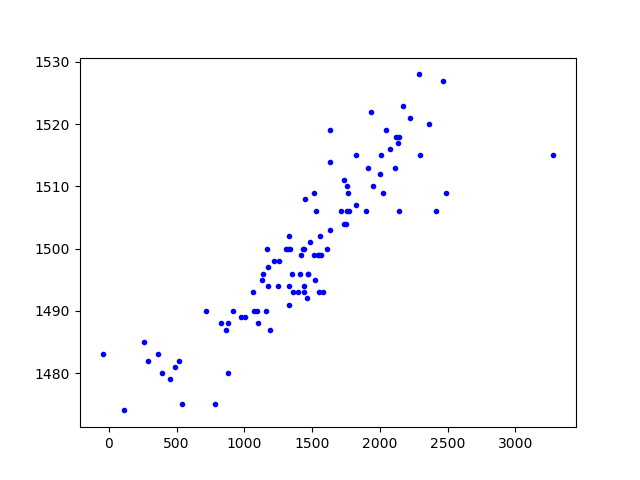

<IPython.core.display.Javascript object>


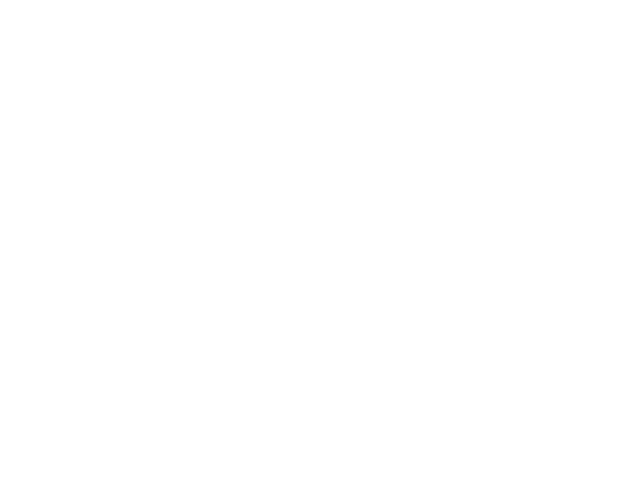

,skill,rating
skill,1.000000,0.881769
rating,0.881769,1.000000


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
df,ims = simulate_rating(100,10,"increment")
fig = plt.figure()    
ani = animation.ArtistAnimation(fig,ims,repeat=False,interval=10)
plt.show()
df.corr()

In [46]:
ani = animation.ArtistAnimation(fig,ims,repeat=False,interval=10)
plt.show()